In [58]:
import os
import keras
import io
import csv
import time
import datetime

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dropout, SimpleRNN, LSTM
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import keras_metrics
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D 


## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import time


In [12]:
##Set params for the model
tensorBoard_logs_dir = '.\\logs\\'
model_dir = '.\\models\\'
glove_dir = '.\\models\\glove'
train_dir = '.\\data\\train'
train_data = 'transmessages.csv'
label_data = 'labels.csv'
train_engdata = 'engmessages.csv'
label_engdata = 'englabels.csv'

maxlen = 100
training_samples = 2800
validation_samples = 500# len(labels) - training_samples #
training_engsamples = 22000
validation_engsamples = 2000# len(labels) - training_samples #

max_words = 10000
num_filters = 64 
embedding_dim = 100
num_filters = 64 
num_classes = 3



In [34]:
texts = []
labels = []

with open(os.path.join(train_dir, train_engdata), newline ='') as messageData:
    reader = csv.reader(messageData)
    for row in reader:
        message = (''.join(row))
        texts.append(message)

with open(os.path.join(train_dir, label_engdata)) as labelData:
    reader = csv.reader(labelData)
    for row in reader:
        #label = (''.join(row))
        labels.append(row)
np.squeeze(labels[:])


array(['2', '1', '1', ..., '1', '1', '2'], dtype='<U1')

In [35]:
'''
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels,)
labells = np_utils.to_categorical(encoded_Y)
print(labells[0,])

'''
labells = np_utils.to_categorical(labels, num_classes=num_classes)
labells[0:20,]
np.sum(labells, axis = 0)

array([ 1430., 19190.,  4163.], dtype=float32)

In [39]:
##Tokenizer, Sequencer and padding via Keras
np.random.seed(1) 

#tokenize the data for the maxwords
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

#Generate the sequences on texts on the the data by tokenizer
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))
#print(word_index)
#Padding sequences (making them all equal)
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of the data tensor:' , data.shape)
print('Shape of the label tensor:' , labells.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labells[indices,:]

x_train = data[:training_engsamples]
y_train = labels[:training_engsamples]

x_test = data[training_samples:training_samples + validation_samples]
y_test = labels[training_samples:training_samples + validation_samples]

print("Train length" , len(x_train))
print("Test length" , len(x_test))

with open(os.path.join(tensorBoard_logs_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, y_test)


Found 21214 unique tokens.
Shape of the data tensor: (24783, 100)
Shape of the label tensor: (24783, 3)
Train length 22000
Test length 500


In [37]:
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [38]:
np.random.seed(1) 
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
   # print(word)
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()


print('Found %s word vectors' % len(embedding_index))

Found 400000 word vectors


In [40]:
np.random.seed(1) 
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)       
#embedding_matrix[0:10, ]

(10000, 100)


In [95]:
def save_model(model_qualifier, model, location):
    model_name = model_qualifier + "-{}".format(datetime.date.today()) + "-{}".format(time.time()) + ".h5"
    try:
        model.save(os.path.join(location, model_name))
        #plot_model(model, to_file=os.path.join(location, model_name)+ '.png')
    except:
        print("Exception occured while saving the model to disc.")

In [101]:
np.random.seed(1) 
model = Sequential() 
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
'''
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32))

'''
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(3, activation = 'softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()
model_name = "English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2-{}".format(int(time.time()))


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
batch_normalization_29 (Batc (None, 100, 64)           256       
_________________________________________________________________
dropout_53 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
batch_normalization_30 (Batc (None, 50, 64)          

In [102]:
optimizer = Adam(learning_rate=0.01, decay=1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['acc'])

In [103]:
#callbacks 
earlystopping = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=40, restore_best_weights= True)

modelcheckpoint = ModelCheckpoint('.\\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5', monitor='val_acc', mode='min', verbose=1)

reduce_lr_plateau = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


tensorboard = TensorBoard(log_dir = tensorBoard_logs_dir + '{}'.format(model_name), 
                         histogram_freq=1,
                         #embeddings_freq=1
                         )

In [104]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 512,validation_split=0.1, callbacks = [tensorboard, earlystopping, reduce_lr_plateau, modelcheckpoint])
results = model.evaluate(x_test, y_test)
model.save_weights(model_dir + '{}'.format(model_name)+'.h5')
save_model("English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2", model, ".\\models")

Train on 19800 samples, validate on 2200 samples
Epoch 1/100
19800/19800 [==============================] - 44s 2ms/step - loss: 0.8472 - acc: 0.7237 - val_loss: 0.6483 - val_acc: 0.7750

Epoch 00001: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 2/100
19800/19800 [==============================] - 35s 2ms/step - loss: 0.5626 - acc: 0.7940 - val_loss: 0.5486 - val_acc: 0.8455

Epoch 00002: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 3/100
19800/19800 [==============================] - 31s 2ms/step - loss: 0.4707 - acc: 0.8361 - val_loss: 0.5272 - val_acc: 0.8577

Epoch 00003: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 4/100
19800/19800 [==============================] - 30s 2ms/step - loss: 0.4232 - acc: 0.8564 - val_loss: 0.4953 - val_acc: 0.8541

Epoch 00004: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 5/100
19800/19800

Epoch 00035: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 36/100
19800/19800 [==============================] - 27s 1ms/step - loss: 0.2078 - acc: 0.9227 - val_loss: 0.3776 - val_acc: 0.8709

Epoch 00036: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 37/100
19800/19800 [==============================] - 27s 1ms/step - loss: 0.2005 - acc: 0.9235 - val_loss: 0.3919 - val_acc: 0.8659

Epoch 00037: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 38/100
19800/19800 [==============================] - 27s 1ms/step - loss: 0.2020 - acc: 0.9238 - val_loss: 0.3989 - val_acc: 0.8668

Epoch 00038: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x3_DO-Dense_64x2_model.h5
Epoch 39/100
19800/19800 [==============================] - 27s 1ms/step - loss: 0.2005 - acc: 0.9247 - val_loss: 0.3890 - val_acc: 0.8668

Epoch 00039: saving model to .\models\Best_English-Emb-TFL-CNN_64x7x

In [77]:
os.getcwd()

'C:\\Users\\vigupta\\source\\repos\\CodeMixed-Hinglish'

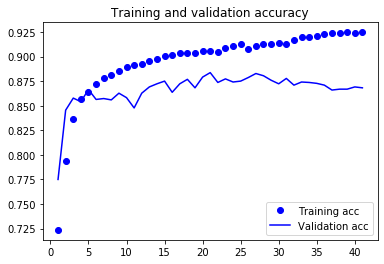

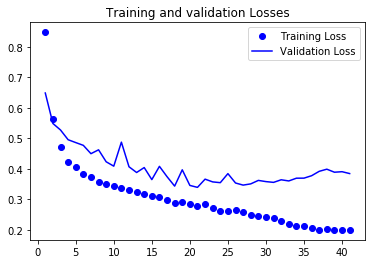

<Figure size 432x288 with 0 Axes>

In [105]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label ='Validation acc')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label ='Training Loss')
plt.plot(epochs, val_loss, 'b', label ='Validation Loss')
plt.title("Training and validation Losses")
plt.legend()
plt.figure()

plt.show()

In [106]:
print(model.metrics_names)
results

['loss', 'acc']


[0.613394326210022, 0.8100000023841858]

In [107]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

weights[1:20, 0:10]

(10000, 100)


array([[ 3.3097e-01,  8.2649e-02,  6.6941e-01, -8.0890e-01, -2.2723e-01,
         3.6855e-01,  2.5496e-01,  1.4880e-01,  2.4357e-01,  1.1173e-01],
       [ 1.5731e-01,  3.9530e-01,  6.3586e-01, -1.0975e+00, -9.5768e-01,
        -1.3841e-02, -1.9853e-01,  2.5418e-01,  3.6731e-01, -1.7486e-01],
       [ 6.7826e-01,  4.8788e-02,  5.8604e-01, -8.6665e-01, -8.4912e-01,
         3.1358e-01,  2.4237e-01, -1.1072e-01, -1.8458e-01, -4.1500e-01],
       [-2.6870e-01,  8.1708e-01,  6.9896e-01, -7.2341e-01,  9.1566e-02,
         1.9557e-01, -5.2112e-01, -2.4313e-01, -4.4701e-01, -2.7039e-01],
       [ 5.8854e-01, -2.0250e-01,  7.3479e-01, -6.8338e-01, -1.9675e-01,
        -1.8020e-01, -3.9177e-01,  3.4172e-01, -6.0561e-01,  6.3816e-01],
       [-7.9756e-02,  2.1322e-01, -8.7372e-01, -7.9387e-01,  6.8266e-02,
        -8.2002e-02,  4.8882e-02,  1.2984e-01,  4.2201e-01,  1.0945e-01],
       [ 2.5839e-01, -1.3339e-01,  2.7551e-01, -8.2961e-01, -4.8300e-01,
         7.1471e-01, -5.7770e-01, -7.8464e-01

In [76]:
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

In [51]:
tsne_embeddings = TSNE(n_components=2).fit_transform(weights)
plot_words(tsne_embeddings, 0, 2, 1)

NameError: name 'word_list' is not defined